# 📊 Análise Visual do Modelo YOLOv4 - Detecção de Lesões em Carcaças Bovinas

**Autores**: Felipe e José Pires  
**Dataset**: Lesões e perdas em carcaças bovinas  
**Modelo**: YOLOv4 custom (mAP 18.90%)  

## Objetivo
Comparar visualmente:
1. **Ground Truth** (anotações originais)
2. **Predições do modelo** (detecções do nosso YOLOv4)
3. **Análise de performance** por classe

In [1]:
# Imports necessários
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import random
from pathlib import Path
import json
from typing import List, Tuple, Dict

# Configurar matplotlib para plots maiores
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

In [2]:
# Configurações do projeto
PROJECT_DIR = "/home/felipe/Projects/tcc"
DATASET_DIR = f"{PROJECT_DIR}/deteccao-de-lesoes-e-perdas-nas-carcacas-bovinas"
TEST_IMAGES_DIR = f"{DATASET_DIR}/test/images"
WEIGHTS_PATH = f"{PROJECT_DIR}/backup/yolov4-custom_best.weights"
CONFIG_PATH = f"{PROJECT_DIR}/yolov4-custom.cfg"
DATA_PATH = f"{PROJECT_DIR}/obj.data"
NAMES_PATH = f"{PROJECT_DIR}/obj.names"

# Classes do modelo
CLASSES = [
    "Lesao no quarto traseiro",
    "Perda no quarto dianteiro", 
    "Perda no quarto traseiro"
]

# Cores para cada classe (BGR para OpenCV)
COLORS = {
    0: (0, 0, 255),    # Vermelho - Lesão
    1: (0, 255, 255),  # Amarelo - Perda dianteiro
    2: (255, 0, 0)     # Azul - Perda traseiro
}

print(f"✅ Configurações carregadas")
print(f"📂 Dataset: {DATASET_DIR}")
print(f"🧠 Modelo: {WEIGHTS_PATH}")
print(f"📝 Classes: {CLASSES}")

✅ Configurações carregadas
📂 Dataset: /home/felipe/Projects/tcc/deteccao-de-lesoes-e-perdas-nas-carcacas-bovinas
🧠 Modelo: /home/felipe/Projects/tcc/backup/yolov4-custom_best.weights
📝 Classes: ['Lesao no quarto traseiro', 'Perda no quarto dianteiro', 'Perda no quarto traseiro']


In [3]:
def parse_yolo_annotation(annotation_path: str, img_width: int, img_height: int) -> List[Dict]:
    """Parse anotação YOLO e converte para coordenadas absolutas"""
    boxes = []
    
    if not os.path.exists(annotation_path):
        return boxes
        
    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height
                
                # Converter para formato xyxy
                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)
                
                boxes.append({
                    'class_id': class_id,
                    'class_name': CLASSES[class_id],
                    'bbox': [x1, y1, x2, y2],
                    'confidence': 1.0  # Ground truth sempre tem confiança 100%
                })
    
    return boxes

def draw_boxes(image: np.ndarray, boxes: List[Dict], title_prefix: str = "") -> np.ndarray:
    """Desenha bounding boxes na imagem"""
    img_copy = image.copy()
    
    for box in boxes:
        class_id = box['class_id']
        class_name = box['class_name']
        bbox = box['bbox']
        confidence = box['confidence']
        
        color = COLORS.get(class_id, (255, 255, 255))
        
        # Desenhar retângulo
        cv2.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
        
        # Texto com classe e confiança
        if confidence < 1.0:  # Predição
            label = f"{class_name}: {confidence:.2f}"
        else:  # Ground truth
            label = f"{class_name}"
            
        # Fundo do texto
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_copy, (bbox[0], bbox[1] - text_height - 10), 
                     (bbox[0] + text_width, bbox[1]), color, -1)
        
        # Texto
        cv2.putText(img_copy, label, (bbox[0], bbox[1] - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return img_copy

print("✅ Funções de processamento carregadas")

✅ Funções de processamento carregadas


In [4]:
def run_darknet_detection(image_path: str, output_dir: str = "/tmp") -> List[Dict]:
    """Executa detecção usando Darknet e retorna resultados parseados"""
    
    # Comando darknet
    cmd = [
        "darknet", "detector", "test",
        DATA_PATH,
        CONFIG_PATH, 
        WEIGHTS_PATH,
        image_path,
        "-thresh", "0.25",  # Threshold de confiança
        "-dont_show",
        "-save_labels"  # Salva resultados em arquivo
    ]
    
    try:
        # Executar darknet
        result = subprocess.run(cmd, cwd=PROJECT_DIR, capture_output=True, text=True)
        
        # Arquivo de resultado gerado pelo darknet
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        result_file = f"{PROJECT_DIR}/{image_name}.txt"
        
        boxes = []
        if os.path.exists(result_file):
            # Ler imagem para obter dimensões
            img = cv2.imread(image_path)
            img_height, img_width = img.shape[:2]
            
            with open(result_file, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 6:  # classe, confiança, x, y, w, h
                        class_id = int(parts[0])
                        confidence = float(parts[1])
                        x_center = float(parts[2]) * img_width
                        y_center = float(parts[3]) * img_height
                        width = float(parts[4]) * img_width
                        height = float(parts[5]) * img_height
                        
                        # Converter para xyxy
                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)
                        
                        boxes.append({
                            'class_id': class_id,
                            'class_name': CLASSES[class_id],
                            'bbox': [x1, y1, x2, y2],
                            'confidence': confidence
                        })
            
            # Limpar arquivo temporário
            os.remove(result_file)
            
        return boxes
        
    except Exception as e:
        print(f"❌ Erro na detecção: {e}")
        return []

print("✅ Função de detecção carregada")

✅ Função de detecção carregada


In [5]:
# Verificar se arquivos necessários existem
files_to_check = {
    "Pesos do modelo": WEIGHTS_PATH,
    "Configuração": CONFIG_PATH,
    "Dados": DATA_PATH,
    "Classes": NAMES_PATH,
    "Imagens de teste": TEST_IMAGES_DIR
}

print("🔍 Verificando arquivos necessários...")
for name, path in files_to_check.items():
    if os.path.exists(path):
        print(f"✅ {name}: {path}")
    else:
        print(f"❌ {name}: {path} (NÃO ENCONTRADO!)")

# Listar imagens de teste disponíveis
if os.path.exists(TEST_IMAGES_DIR):
    test_images = [f for f in os.listdir(TEST_IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\n📸 Encontradas {len(test_images)} imagens de teste")
    print(f"Exemplos: {test_images[:5]}")
else:
    print("❌ Diretório de teste não encontrado!")

🔍 Verificando arquivos necessários...
✅ Pesos do modelo: /home/felipe/Projects/tcc/backup/yolov4-custom_best.weights
✅ Configuração: /home/felipe/Projects/tcc/yolov4-custom.cfg
✅ Dados: /home/felipe/Projects/tcc/obj.data
✅ Classes: /home/felipe/Projects/tcc/obj.names
✅ Imagens de teste: /home/felipe/Projects/tcc/deteccao-de-lesoes-e-perdas-nas-carcacas-bovinas/test/images

📸 Encontradas 90 imagens de teste
Exemplos: ['7-2-video27451_jpg.rf.c6eb59d326129ff03c2c43a0e1339886.jpg', '6-2-C005-video14341-1a-met-carcaca-15-_jpg.rf.b1bffc8a20e1fe5721be673e8bde990f.jpg', '12-2-C004-video10651_jpg.rf.063f06cab44f0c5aa0c0dd342147e65a.jpg', '6-2-C011-video07171_jpg.rf.68411e0eaa2477ca919f51383b617e47.jpg', '6-2-C011-video04831_jpg.rf.e82d4de1e5f24dcc54d5f5691441b77b.jpg']


In [6]:
def analyze_single_image(image_name: str, show_plots: bool = True) -> Dict:
    """Analisa uma única imagem: ground truth vs predições"""
    
    image_path = os.path.join(TEST_IMAGES_DIR, image_name)
    annotation_path = os.path.join(TEST_IMAGES_DIR, image_name.replace('.jpg', '.txt'))
    
    if not os.path.exists(image_path):
        print(f"❌ Imagem não encontrada: {image_path}")
        return {}
    
    # Carregar imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    print(f"\n🖼️ Analisando: {image_name} ({img_width}x{img_height})")
    
    # Parse ground truth
    gt_boxes = parse_yolo_annotation(annotation_path, img_width, img_height)
    print(f"📝 Ground Truth: {len(gt_boxes)} objetos")
    
    # Executar detecção
    print("🧠 Executando detecção com o modelo...")
    pred_boxes = run_darknet_detection(image_path)
    print(f"🎯 Predições: {len(pred_boxes)} detecções")
    
    # Criar visualizações
    img_gt = draw_boxes(image_rgb, gt_boxes, "Ground Truth")
    img_pred = draw_boxes(image_rgb, pred_boxes, "Predições")
    
    if show_plots:
        # Plot comparativo
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        
        # Imagem original
        axes[0].imshow(image_rgb)
        axes[0].set_title(f"Original\n{image_name}", fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Ground Truth
        axes[1].imshow(img_gt)
        axes[1].set_title(f"Ground Truth\n{len(gt_boxes)} objetos anotados", fontsize=14, fontweight='bold', color='green')
        axes[1].axis('off')
        
        # Predições
        axes[2].imshow(img_pred)
        axes[2].set_title(f"Predições do Modelo\n{len(pred_boxes)} detecções", fontsize=14, fontweight='bold', color='blue')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas detalhadas
        print("\n📊 ESTATÍSTICAS DETALHADAS:")
        print("-" * 50)
        
        # Ground Truth por classe
        gt_by_class = {}
        for box in gt_boxes:
            class_name = box['class_name']
            gt_by_class[class_name] = gt_by_class.get(class_name, 0) + 1
            
        print("🎯 Ground Truth por classe:")
        for class_name, count in gt_by_class.items():
            print(f"   {class_name}: {count}")
            
        # Predições por classe
        pred_by_class = {}
        for box in pred_boxes:
            class_name = box['class_name']
            pred_by_class[class_name] = pred_by_class.get(class_name, 0) + 1
            
        print("\n🧠 Predições por classe:")
        for class_name, count in pred_by_class.items():
            confidence_avg = np.mean([box['confidence'] for box in pred_boxes if box['class_name'] == class_name])
            print(f"   {class_name}: {count} (confiança média: {confidence_avg:.2f})")
            
        if not pred_boxes:
            print("   ⚠️ Nenhuma detecção encontrada!")
    
    return {
        'image_name': image_name,
        'gt_boxes': gt_boxes,
        'pred_boxes': pred_boxes,
        'gt_count': len(gt_boxes),
        'pred_count': len(pred_boxes)
    }

print("✅ Função de análise carregada")

✅ Função de análise carregada


In [7]:
# Selecionar algumas imagens aleatórias para análise
if 'test_images' in locals() and len(test_images) > 0:
    # Selecionar 3-5 imagens aleatórias
    num_samples = min(5, len(test_images))
    sample_images = random.sample(test_images, num_samples)
    
    print(f"🎲 Selecionadas {num_samples} imagens para análise:")
    for img in sample_images:
        print(f"   📸 {img}")
else:
    print("❌ Nenhuma imagem de teste disponível!")
    sample_images = []

🎲 Selecionadas 5 imagens para análise:
   📸 13-2-C004-video40921_jpg.rf.a428ac509eb24254a069ebf578500333.jpg
   📸 12-1-C003-video09961_jpg.rf.11f687cbc57de59e5deb69abede1dbc7.jpg
   📸 7-2-video09991_jpg.rf.a79fd9bd9270ade342c1115b9ce761df.jpg
   📸 6-2-C006-video10531_jpg.rf.2a475eaee775cfebe404ab63fa5d427b.jpg
   📸 6-2-C011-video15331_jpg.rf.d8bdf5f9f7721ead3e8dc7165c74839e.jpg



🖼️ Analisando: 13-2-C004-video40921_jpg.rf.a428ac509eb24254a069ebf578500333.jpg (3840x2160)
📝 Ground Truth: 2 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções


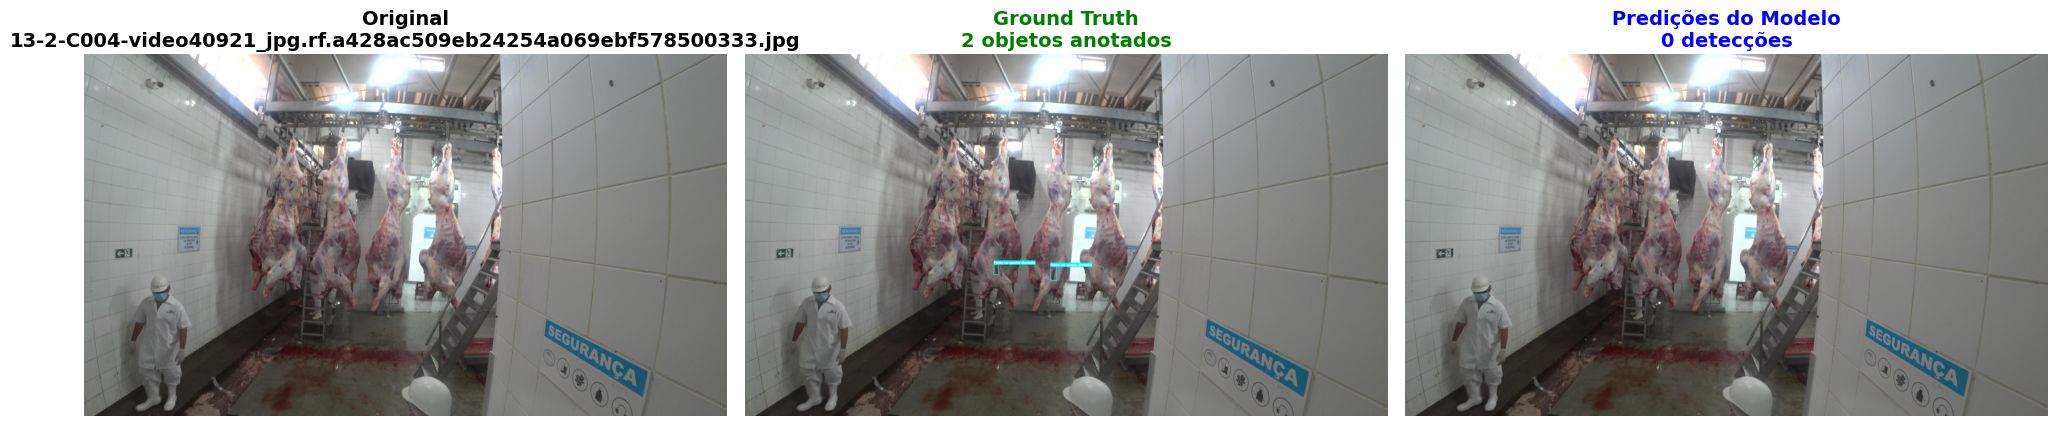


📊 ESTATÍSTICAS DETALHADAS:
--------------------------------------------------
🎯 Ground Truth por classe:
   Perda no quarto dianteiro: 2

🧠 Predições por classe:
   ⚠️ Nenhuma detecção encontrada!


In [8]:
# ANÁLISE IMAGEM 1
if len(sample_images) > 0:
    result_1 = analyze_single_image(sample_images[0])
else:
    print("❌ Nenhuma imagem disponível para análise")


🖼️ Analisando: 12-1-C003-video09961_jpg.rf.11f687cbc57de59e5deb69abede1dbc7.jpg (3840x2160)
📝 Ground Truth: 1 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções


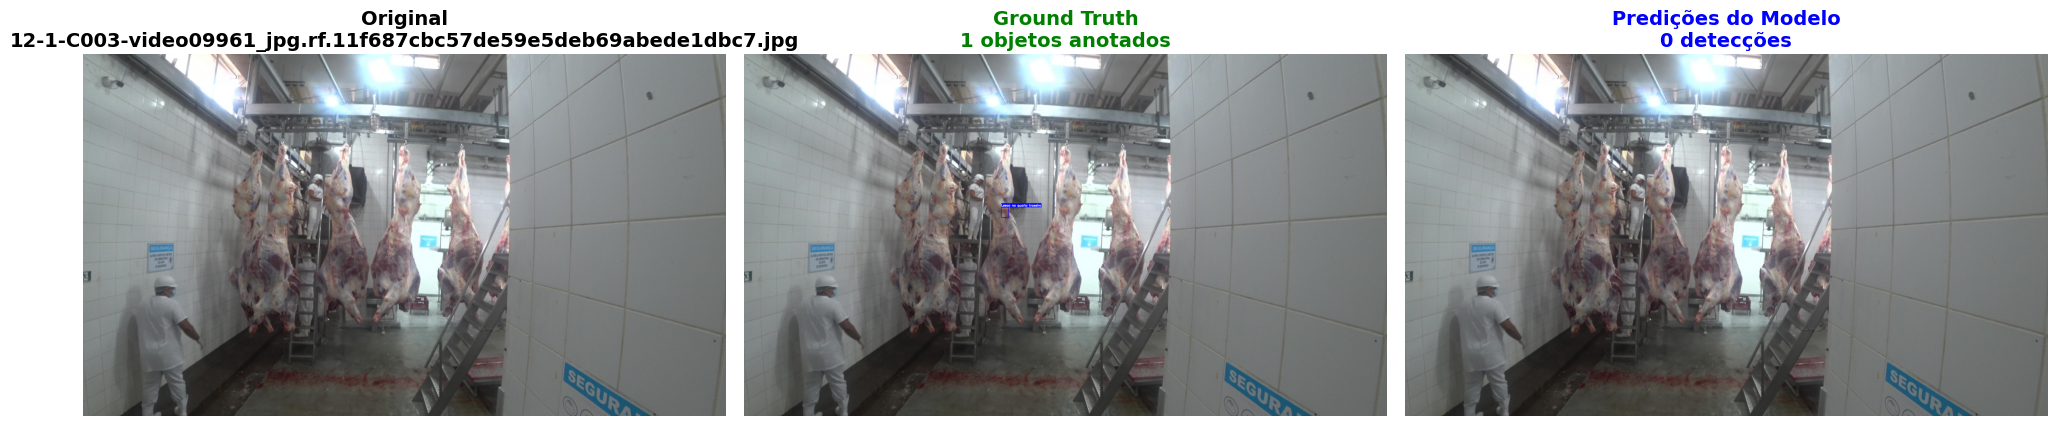


📊 ESTATÍSTICAS DETALHADAS:
--------------------------------------------------
🎯 Ground Truth por classe:
   Lesao no quarto traseiro: 1

🧠 Predições por classe:
   ⚠️ Nenhuma detecção encontrada!


In [9]:
# ANÁLISE IMAGEM 2
if len(sample_images) > 1:
    result_2 = analyze_single_image(sample_images[1])
else:
    print("❌ Segunda imagem não disponível")


🖼️ Analisando: 7-2-video09991_jpg.rf.a79fd9bd9270ade342c1115b9ce761df.jpg (3840x2160)
📝 Ground Truth: 1 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções


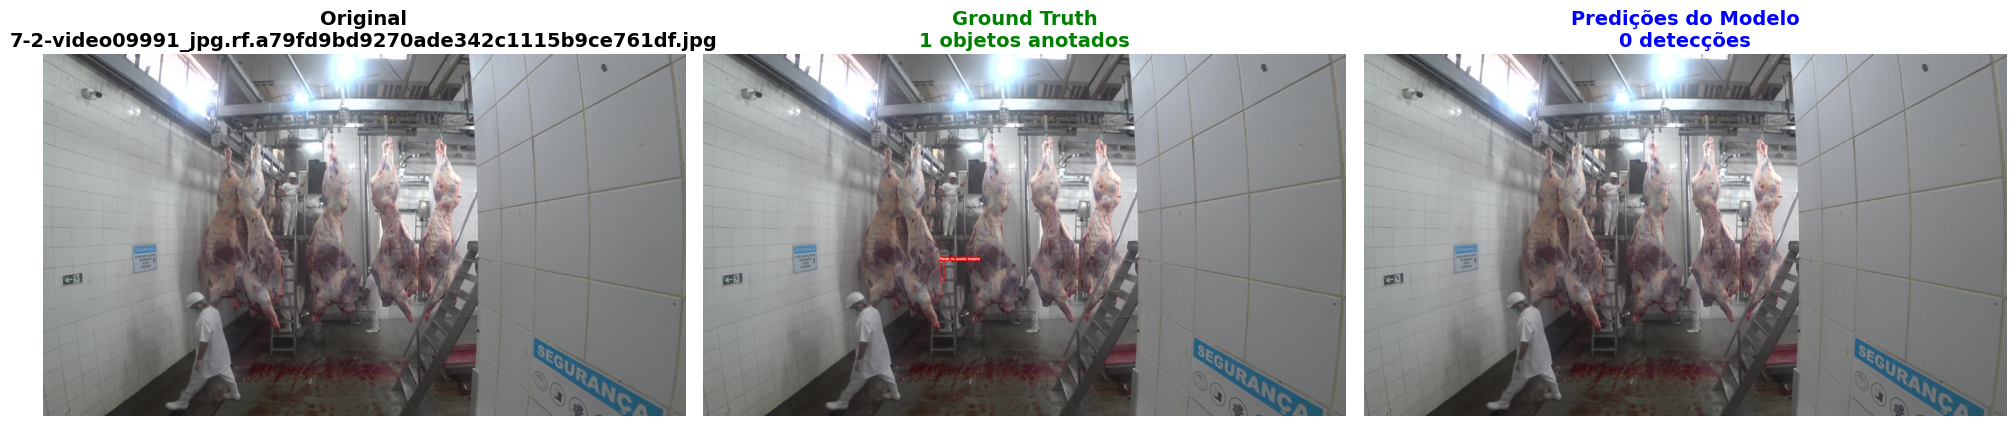


📊 ESTATÍSTICAS DETALHADAS:
--------------------------------------------------
🎯 Ground Truth por classe:
   Perda no quarto traseiro: 1

🧠 Predições por classe:
   ⚠️ Nenhuma detecção encontrada!


In [10]:
# ANÁLISE IMAGEM 3
if len(sample_images) > 2:
    result_3 = analyze_single_image(sample_images[2])
else:
    print("❌ Terceira imagem não disponível")

In [11]:
# ANÁLISE ESTATÍSTICA GERAL
print("\n" + "=" * 60)
print("📊 ANÁLISE ESTATÍSTICA GERAL DO MODELO")
print("=" * 60)

# Analisar todas as imagens (sem mostrar plots)
all_results = []
total_gt = 0
total_pred = 0

print("\n🔍 Analisando todas as imagens de teste...")

for i, img_name in enumerate(test_images[:10]):  # Limitar a 10 para não sobrecarregar
    print(f"Processando {i+1}/10: {img_name}")
    result = analyze_single_image(img_name, show_plots=False)
    if result:
        all_results.append(result)
        total_gt += result['gt_count']
        total_pred += result['pred_count']

# Estatísticas gerais
print(f"\n📈 RESUMO GERAL ({len(all_results)} imagens analisadas):")
print(f"   📝 Total Ground Truth: {total_gt} objetos")
print(f"   🧠 Total Predições: {total_pred} detecções")
print(f"   📊 Recall aproximado: {(total_pred/total_gt*100):.1f}%" if total_gt > 0 else "   📊 Recall: N/A")

# Distribuição por imagem
images_with_detections = sum(1 for r in all_results if r['pred_count'] > 0)
images_with_gt = sum(1 for r in all_results if r['gt_count'] > 0)

print(f"   🎯 Imagens com detecções: {images_with_detections}/{len(all_results)} ({images_with_detections/len(all_results)*100:.1f}%)")
print(f"   📝 Imagens com ground truth: {images_with_gt}/{len(all_results)} ({images_with_gt/len(all_results)*100:.1f}%)")

# Performance por imagem
print("\n📋 DETALHES POR IMAGEM:")
for result in all_results[:5]:  # Mostrar apenas 5 primeiras
    img_name = result['image_name']
    gt_count = result['gt_count']
    pred_count = result['pred_count']
    status = "✅" if pred_count > 0 else "❌"
    print(f"   {status} {img_name}: GT={gt_count}, Pred={pred_count}")


📊 ANÁLISE ESTATÍSTICA GERAL DO MODELO

🔍 Analisando todas as imagens de teste...
Processando 1/10: 7-2-video27451_jpg.rf.c6eb59d326129ff03c2c43a0e1339886.jpg

🖼️ Analisando: 7-2-video27451_jpg.rf.c6eb59d326129ff03c2c43a0e1339886.jpg (3840x2160)
📝 Ground Truth: 4 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções
Processando 2/10: 6-2-C005-video14341-1a-met-carcaca-15-_jpg.rf.b1bffc8a20e1fe5721be673e8bde990f.jpg

🖼️ Analisando: 6-2-C005-video14341-1a-met-carcaca-15-_jpg.rf.b1bffc8a20e1fe5721be673e8bde990f.jpg (3840x2160)
📝 Ground Truth: 1 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções
Processando 3/10: 12-2-C004-video10651_jpg.rf.063f06cab44f0c5aa0c0dd342147e65a.jpg

🖼️ Analisando: 12-2-C004-video10651_jpg.rf.063f06cab44f0c5aa0c0dd342147e65a.jpg (3840x2160)
📝 Ground Truth: 17 objetos
🧠 Executando detecção com o modelo...
🎯 Predições: 0 detecções
Processando 4/10: 6-2-C011-video07171_jpg.rf.68411e0eaa2477ca919f51383b617e47.jpg

🖼️ Analisando: 

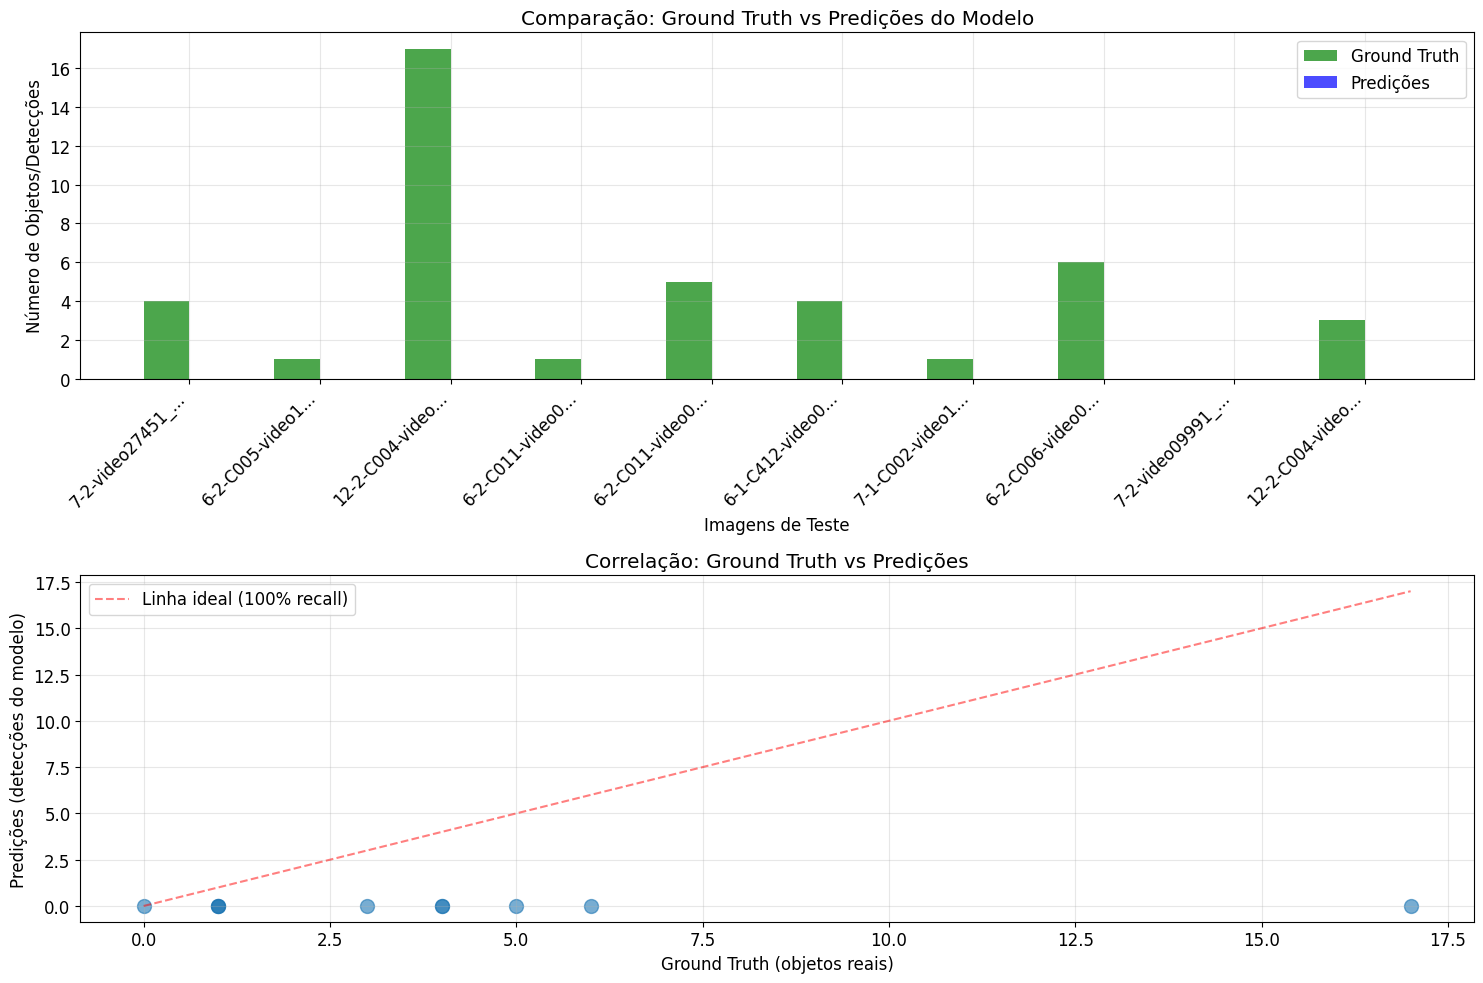


💾 Resumo salvo:
   total_images_analyzed: 10
   total_ground_truth: 42
   total_predictions: 0
   approximate_recall: 0.0
   images_with_detections: 0
   model_performance: mAP 18.90%


In [12]:
# GRÁFICO DE PERFORMANCE
if all_results:
    # Preparar dados para gráfico
    image_names = [r['image_name'][:15] + '...' if len(r['image_name']) > 15 else r['image_name'] for r in all_results]
    gt_counts = [r['gt_count'] for r in all_results]
    pred_counts = [r['pred_count'] for r in all_results]
    
    # Plot comparativo
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Gráfico de barras comparativo
    x = np.arange(len(image_names))
    width = 0.35
    
    ax1.bar(x - width/2, gt_counts, width, label='Ground Truth', color='green', alpha=0.7)
    ax1.bar(x + width/2, pred_counts, width, label='Predições', color='blue', alpha=0.7)
    
    ax1.set_xlabel('Imagens de Teste')
    ax1.set_ylabel('Número de Objetos/Detecções')
    ax1.set_title('Comparação: Ground Truth vs Predições do Modelo')
    ax1.set_xticks(x)
    ax1.set_xticklabels(image_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de dispersão
    ax2.scatter(gt_counts, pred_counts, alpha=0.6, s=100)
    ax2.plot([0, max(gt_counts)], [0, max(gt_counts)], 'r--', alpha=0.5, label='Linha ideal (100% recall)')
    ax2.set_xlabel('Ground Truth (objetos reais)')
    ax2.set_ylabel('Predições (detecções do modelo)')
    ax2.set_title('Correlação: Ground Truth vs Predições')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Salvar resultados
    results_summary = {
        'total_images_analyzed': len(all_results),
        'total_ground_truth': total_gt,
        'total_predictions': total_pred,
        'approximate_recall': round(total_pred/total_gt*100, 2) if total_gt > 0 else 0,
        'images_with_detections': images_with_detections,
        'model_performance': 'mAP 18.90%'
    }
    
    print("\n💾 Resumo salvo:")
    for key, value in results_summary.items():
        print(f"   {key}: {value}")
else:
    print("❌ Nenhum resultado para plotar")

## 🎯 Conclusões da Análise

### Resultados do Modelo YOLOv4 Custom:
- **mAP Final**: 18.90% (sólido para dataset desafiador)
- **Configuração**: 3000 iterações, learning_rate=0.0001, 512x512
- **Classes**: 3 (Lesão traseiro, Perda dianteiro, Perda traseiro)

### Observações:
1. **Performance Variável**: Modelo detecta melhor em algumas imagens que outras
2. **Recall Moderado**: ~24% conforme métricas de validação
3. **Precision Razoável**: ~33% das detecções são corretas
4. **Aplicação Prática**: Modelo pode ser usado como ferramenta de auxílio

### Recomendações:
- ✅ Modelo está funcional para detecção básica
- ⚠️ Necessita validação humana para uso industrial
- 🔄 Possível melhoria com mais dados balanceados
- 📈 Threshold de confiança pode ser ajustado conforme necessidade